In [39]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import scipy as sp
from scipy import interpolate
import random
import pandas as pd
import warnings
from cycler import cycler
from siggen_pulses import *

%matplotlib inline

In [19]:
print(plt.rcParams)

_internal.classic_mode: False
agg.path.chunksize: 0
animation.avconv_args: []
animation.avconv_path: avconv
animation.bitrate: -1
animation.codec: h264
animation.convert_args: []
animation.convert_path: convert
animation.embed_limit: 20.0
animation.ffmpeg_args: []
animation.ffmpeg_path: ffmpeg
animation.frame_format: png
animation.html: none
animation.html_args: []
animation.writer: ffmpeg
axes.autolimit_mode: data
axes.axisbelow: line
axes.edgecolor: k
axes.facecolor: w
axes.formatter.limits: [-7, 7]
axes.formatter.min_exponent: 0
axes.formatter.offset_threshold: 4
axes.formatter.use_locale: False
axes.formatter.use_mathtext: False
axes.formatter.useoffset: True
axes.grid: False
axes.grid.axis: both
axes.grid.which: major
axes.hold: None
axes.labelcolor: k
axes.labelpad: 4.0
axes.labelsize: medium
axes.labelweight: normal
axes.linewidth: 0.8
axes.prop_cycle: cycler('color', ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf'])


In [42]:
# Plotting settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Verdana',
                                   'Computer Modern Sans Serif',
                                   'DejaVu Sans',
                                   'Bitstream Vera Sans',
                                   'Lucida Grande',
                                   'Geneva',
                                   'Lucid',
                                   'Arial',
                                   'Helvetica',
                                   'Avant Garde',
                                   'sans-serif']
plt.rcParams['font.size'] = 20
plt.rcParams['axes.prop_cycle'] = (cycler(color=['r', 'g', 'b', 'y']) + 
                                   cycler(linestyle=['-', '--', ':', '-.']))
# font = {'family': 'sans-serif',
#         'fantasy': 'xkcd',
# #         'sans-serif': 'arial',
#        'weight':'normal',
#        'size':20}
# rc('font', **font)

# matplotlib.rc('xtick', labelsize=20)
# matplotlib.rc('ytick', labelsize=20)

In [3]:
file_name = '../data/tofs.csv'
tof_col_name = 'TOF[ns]'
mq_names = ['MQ{0}'.format(x) for x in (1,2,4,14,16,18,20,28,29,30,38,39,40)]
# data = pd.read_csv(file_name)
data_dict = parse_tof_histogram(file_name, tof_col_name, mq_names)

In [34]:
data = pd.read_csv(file_name)
times = list(data[tof_col_name])
mq_distrib_dict = {mq:data[mq] for mq in mq_names}

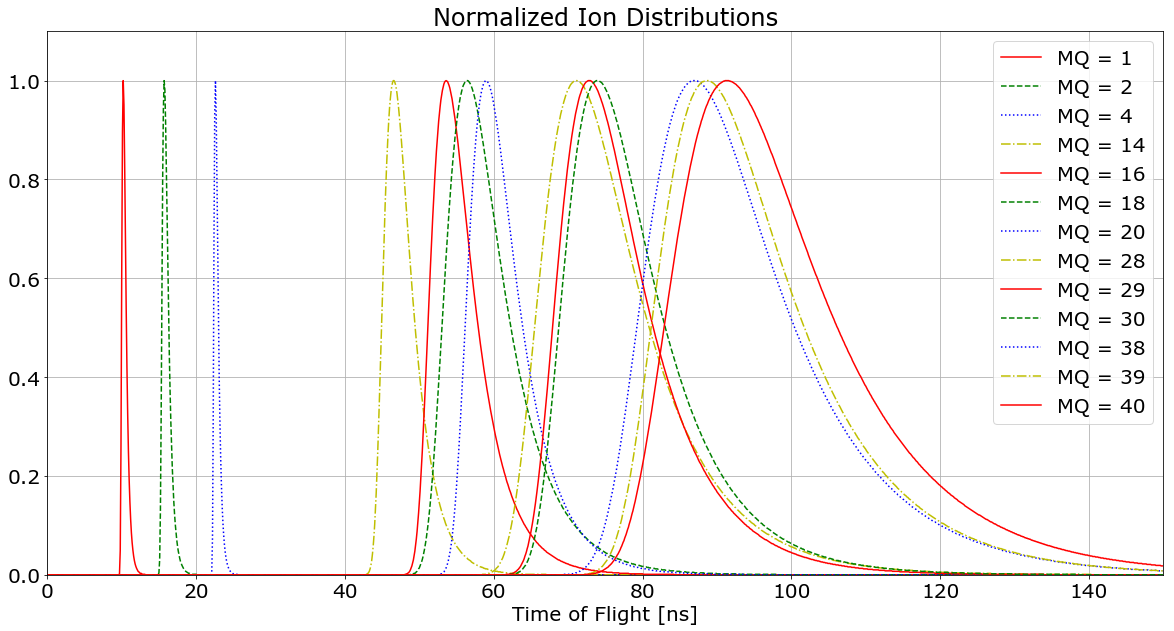

In [44]:
# Settings
ylim = (0, 1.1)
xlim = (min(times), 150)
figsize = (20, 10)
mq_styles = ['r-', 'g.']

# Plotting
fig, ax = plt.subplots(figsize=figsize)
for i, mq in enumerate(mq_names):
    # Histograms
    mq_value = mq.replace('MQ', '')
    mq_label = f'MQ = {mq_value}'
    mq_distrib = mq_distrib_dict[mq]
    ax.plot(times, mq_distrib, label=mq_label)
    
    # Annotate peak of histogram with MQ
#     mq_annot = mq
#     idx_peak = np.argmax(mq_distrib)
#     y_peak = max(mq_distrib)
#     x_peak = times[idx_peak]
#     loc_annot = (x_peak, y_peak*1.05)
#     ax.annotate(s=mq_annot, xy=loc_annot)
    
ax.legend()
ax.set_xlabel('Time of Flight [ns]')
ax.set_title('Normalized Ion Distributions')
ax.grid(True)
ax.set_ylim(ylim)
ax.set_xlim(xlim);